In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
from torch.utils.data import DataLoader
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from dataloader.graph_ts_reader_60 import VitalSignsDataset,vital_pre_train
from model.retnet.autoencoder_v5_retnet import *
from model.retnet.autoencoder_v5_loss_train import *
from model.retnet.plot import *
import seaborn as sns
import matplotlib.pyplot as plt
import gc
gc.collect()
import torch.optim as optim
import torch
torch.cuda.empty_cache()


from torchsampler import ImbalancedDatasetSampler

2025-06-19 21:33:45.186098: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:

vital_signs_train = "/home/mei/nas/docker/thesis/data/hdf/train"
vital_signs_val = "/home/mei/nas/docker/thesis/data/hdf/val"
vital_signs_test = "/home/mei/nas/docker/thesis/data/hdf/val"

dataset_train = VitalSignsDataset(vital_signs_train)
dataset_val = VitalSignsDataset(vital_signs_val)
dataset_test = VitalSignsDataset(vital_signs_test)


train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True, collate_fn=vital_pre_train)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False, collate_fn=vital_pre_train)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False, collate_fn=vital_pre_train)
train_loader_p = DataLoader(dataset_train, batch_size=32, shuffle=False, collate_fn=vital_pre_train)



labels_init = [int(dataset_train[i][-1]) for i in range(len(dataset_train))]
train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_init)
init_loader = DataLoader( dataset_train,batch_size=100,sampler=train_sampler,collate_fn=vital_pre_train )


In [ ]:
# from torch.utils.data import DataLoader, TensorDataset

# vital_signs_train = "/home/mei/nas/docker/thesis/data/hdf/train"
# dataset_train = VitalSignsDataset(vital_signs_train)

# labels_init = [int(dataset_train[i][-1]) for i in range(len(dataset_train))]
# train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_init)
# init_loader = DataLoader( dataset_train,batch_size=100,sampler=train_sampler,collate_fn=vital_pre_train )

# train_loader = DataLoader( dataset_train,batch_size=32,shuffle=True,collate_fn=vital_pre_train )
# small_data_iter = iter(train_loader) 
# inputs, lengths,idx,cat  = next(small_data_iter)   

# original_indices = torch.arange(len(inputs))
# small_dataset = TensorDataset(inputs, lengths, original_indices, cat)

# small_train_loader = DataLoader(small_dataset, batch_size=len(inputs), shuffle=True) 
# small_train_loader_p = DataLoader(small_dataset, batch_size=len(inputs), shuffle=False) 

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_dir = "/home/mei/nas/docker/thesis/data/model_results/retnet/resampled_60"

model = TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=10).to(device)

optimizer_ae = torch.optim.Adam( list(model.encoder.parameters()) + list(model.decoder.parameters()),lr=1e-3)
optimizer_joint = torch.optim.Adam(model.parameters(), lr=1e-4)

In [4]:
stage1_dir = os.path.join(base_dir, "stage1")
# stage1_dir = os.path.join(base_dir, "stage1_debug")

model1, hist_ae = train_vae(model, train_loader, device, optimizer=optimizer_ae, start=0,epochs=300, save_dir=stage1_dir, patience=50,kl_warmup_epochs=240)

[Epoch 50] KL weight: 0.0020, KL: 1.3021
[VAE Pretrain] Epoch 50/300 Avg ELBO: -374.7479 (Recon: -376.0499, KLw: 1.3021)
[Epoch 100] KL weight: 0.0041, KL: 2.9110
[VAE Pretrain] Epoch 100/300 Avg ELBO: -439.1057 (Recon: -442.0167, KLw: 2.9110)
[Epoch 150] KL weight: 0.0062, KL: 4.2990
[VAE Pretrain] Epoch 150/300 Avg ELBO: -456.7447 (Recon: -461.0436, KLw: 4.2990)
[Epoch 200] KL weight: 0.0083, KL: 6.0326
[VAE Pretrain] Epoch 200/300 Avg ELBO: -491.4407 (Recon: -497.4733, KLw: 6.0326)
[Epoch 250] KL weight: 0.0100, KL: 7.2813
[VAE Pretrain] Epoch 250/300 Avg ELBO: -496.0292 (Recon: -503.3105, KLw: 7.2813)
[Epoch 300] KL weight: 0.0100, KL: 7.1746
[VAE Pretrain] Epoch 300/300 Avg ELBO: -481.1302 (Recon: -488.3048, KLw: 7.1746)


In [ ]:
# stage1 = '/home/mei/nas/docker/thesis/data/model_results/autoencoder_v5/resampled_60_vae/stage1_debug/best_vae.pth'
# model1 = TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

# model1.load_state_dict(torch.load(stage1, map_location=device,weights_only=True))

<All keys matched successfully>

In [5]:
initialize_som_from_data(model1, init_loader, device, som_dim=(10, 10), num_classes=4, samples_per_class=25)

[SOM Init] initialize SOM embeddings：100 vectors, each class has 25。


In [6]:
stage2_dir = os.path.join(base_dir, "stage2")
# stage2_dir = os.path.join(base_dir, "stage2_debug")

model2,hist_som = train_som( model1, train_loader, device,max_epochs=90,save_dir=stage2_dir,patience=30)

[SOM] Phase 1 Epoch 10/90 Avg Loss: 0.0113
[SOM] Phase 1 Epoch 20/90 Avg Loss: 0.0113
[SOM] Phase 1 Epoch 30/90 Avg Loss: 0.0113
[SOM] Phase 2 Epoch 40/90 Avg Loss: 0.0104
[SOM] Phase 2 Epoch 50/90 Avg Loss: 0.0103
[SOM] Phase 2 Epoch 60/90 Avg Loss: 0.0103
[SOM] Phase 3 Epoch 70/90 Avg Loss: 0.0102
[SOM] Phase 3 Epoch 80/90 Avg Loss: 0.0102
[SOM] Phase 3 Epoch 90/90 Avg Loss: 0.0102


In [ ]:
# stage2 = '/home/mei/nas/docker/thesis/data/model_results/autoencoder_v5/stage2/best_joint.pth'
# model2 = TSAutoencoder( input_channels=154, latent_dim=64, som_dim=(10,10), lstm_dim=200, dropout=0.5, alpha_som_q=10).to(device)

# model2.load_state_dict(torch.load(stage2, map_location=device,weights_only=True))

In [7]:
stage3_dir = os.path.join(base_dir, "stage3")

# stage3_dir = os.path.join(base_dir, "stage3_debug")

model3,hist_joint =train_joint(model, train_loader, val_loader,train_loader_p, 
                               device,  optimizer=optimizer_joint, 
                                start_epoch=0, epochs=100, save_dir=stage3_dir, kl_warmup_epochs= 50,
                                theta = 1, gamma = 100,kappa= 10, beta= 100, eta= 1,
                                patience =20)

[Joint] Building patient_start_offset_global as dict...


[Joint] Offset dict built for 2150 patients. Total length: 263825


[Joint] Ep10: Calculating global target P...


[Joint] Ep10 Global P updated. Shape: torch.Size([263825, 100])


[Joint] Ep20: Calculating global target P...


[Joint] Ep20 Global P updated. Shape: torch.Size([263825, 100])


[Joint] Early stopping at epoch 21 due to no improvement for 20 epochs.
[Joint] Loading best model weights.


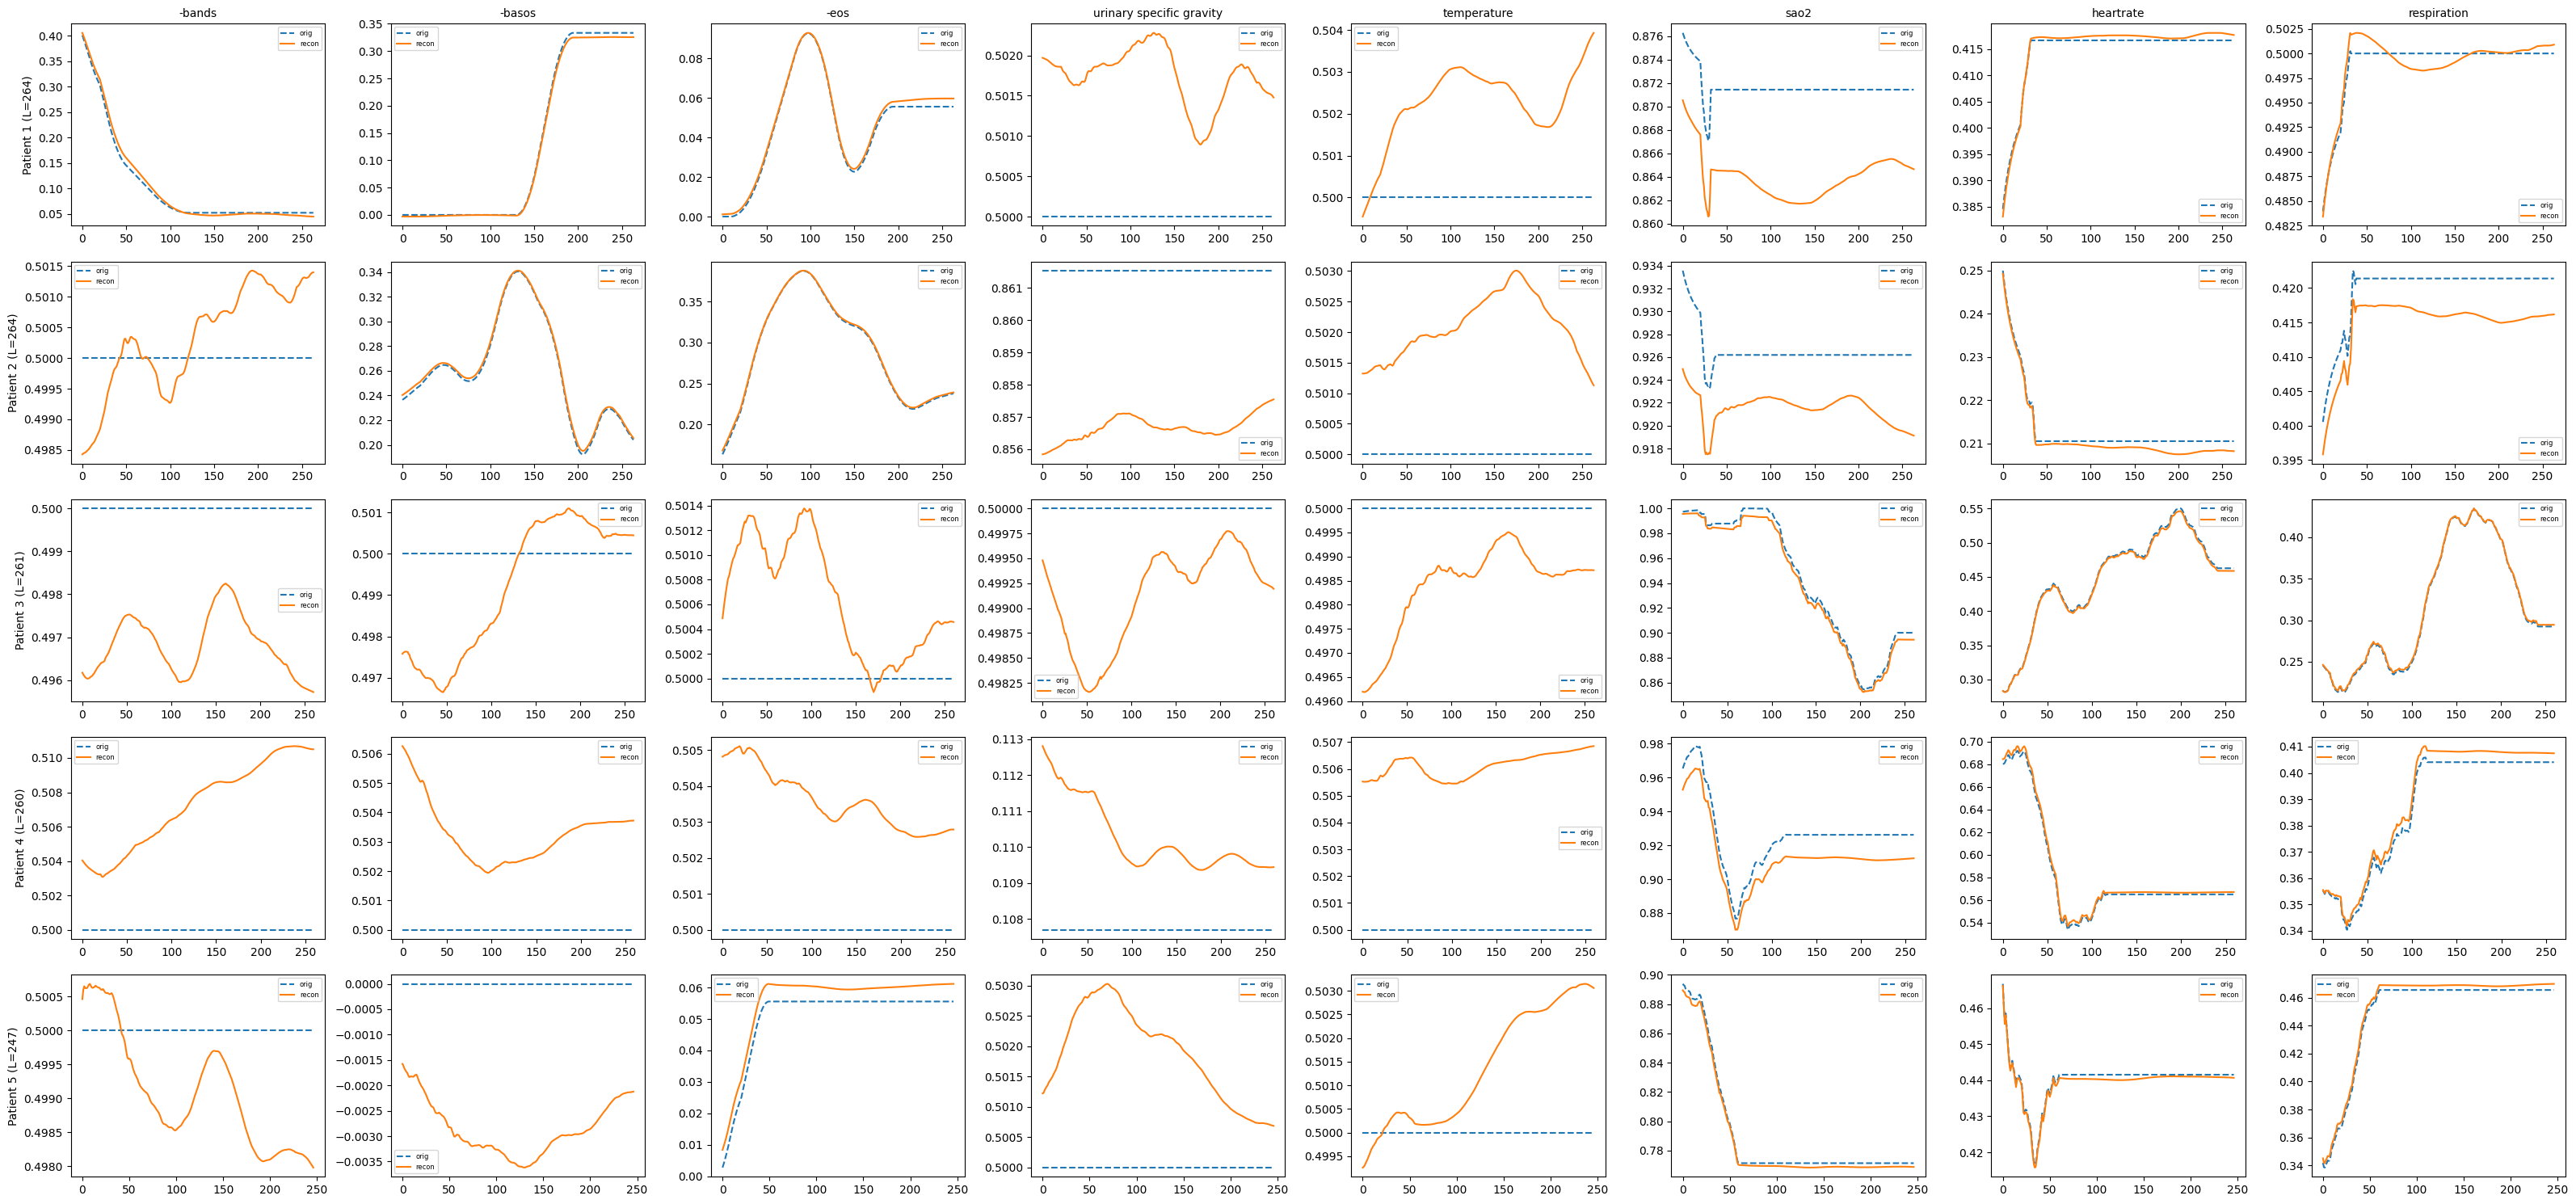

In [8]:
with open('/home/mei/nas/docker/thesis/data/hdf/features.txt', 'r') as f:
    features = [line.strip() for line in f]

selected_feature_indices = [0,1,2,142,143,144,145,146]  #

visualize_recons(model3, train_loader, num_patients=5, feature_indices=selected_feature_indices, feature_names=features,device=device)


--- Latent Space Statistics ---
Analyzed 77628 valid timesteps.

--- mu (Mean of q(z|x)) ---
  Mean (overall): 0.0070
  Std (overall): 0.2075
  Per-dim mean:
tensor([ 4.1359e-02, -8.0878e-03, -2.5172e-02, -4.1169e-02,  7.4198e-03,
        -6.5143e-03, -3.5746e-02,  3.9470e-03, -2.8586e-02,  1.1200e-02,
         1.2359e-02,  6.2891e-03, -7.6615e-03, -6.0475e-03,  2.1462e-02,
         1.2229e-02, -4.8361e-03,  4.0860e-02,  5.3475e-03, -3.6270e-02,
        -8.1259e-03,  1.5016e-02,  2.4911e-02,  2.0300e-02,  1.5589e-02,
         2.2255e-02, -4.9306e-04, -3.6286e-01, -1.2510e-02,  4.9514e-01,
         1.0107e-02, -3.1362e-03, -2.8059e-02,  1.5143e-02, -1.7125e-03,
         3.1101e-02, -2.9361e-03,  2.0325e-03,  7.2605e-03, -1.3300e-02,
        -1.4244e-02,  1.0929e-02, -2.2409e-02,  3.2246e-01,  4.8095e-03,
         1.0613e-02,  4.3993e-03,  4.5134e-02,  2.0367e-02,  2.1444e-02,
        -1.5002e-02,  1.3494e-03,  3.0020e-02,  1.3549e-02,  1.5757e-02,
        -7.9434e-01, -1.7084e-03,  1.7

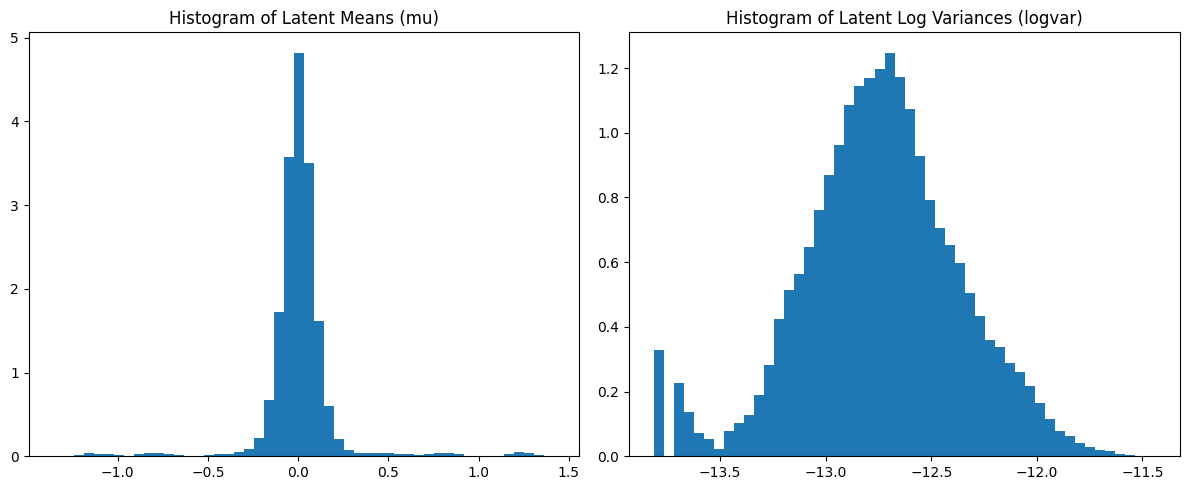

In [9]:
analyze_latent_stats(model3, train_loader, device, num_batches_to_analyze=20)

### vae 几乎退化成 ae， logvar ≈ -11.5（对应 σ² ≈ 1e-5）， 无随机性， kl值过大，与先验不服和

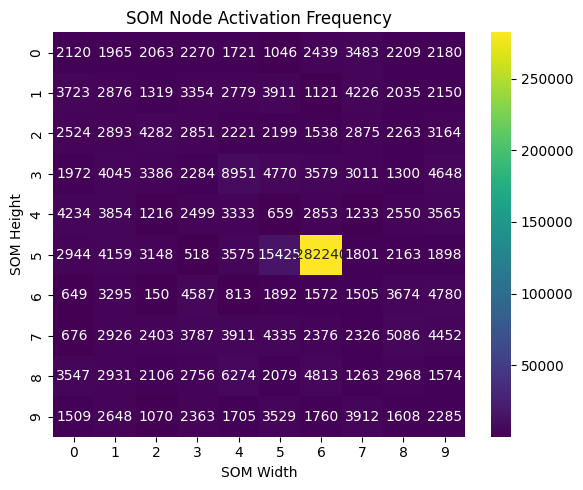

In [10]:
activation_map = compute_som_activation_heatmap(model3, train_loader, device)
plot_som_activation_heatmap(activation_map)

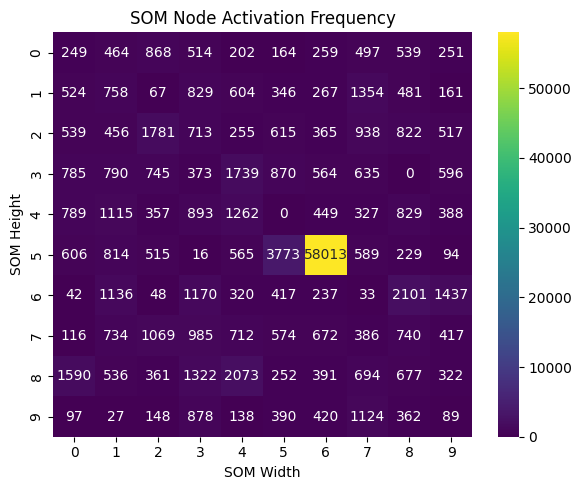

In [17]:
activation_map = compute_som_activation_heatmap(model3, test_loader, device)
plot_som_activation_heatmap(activation_map)

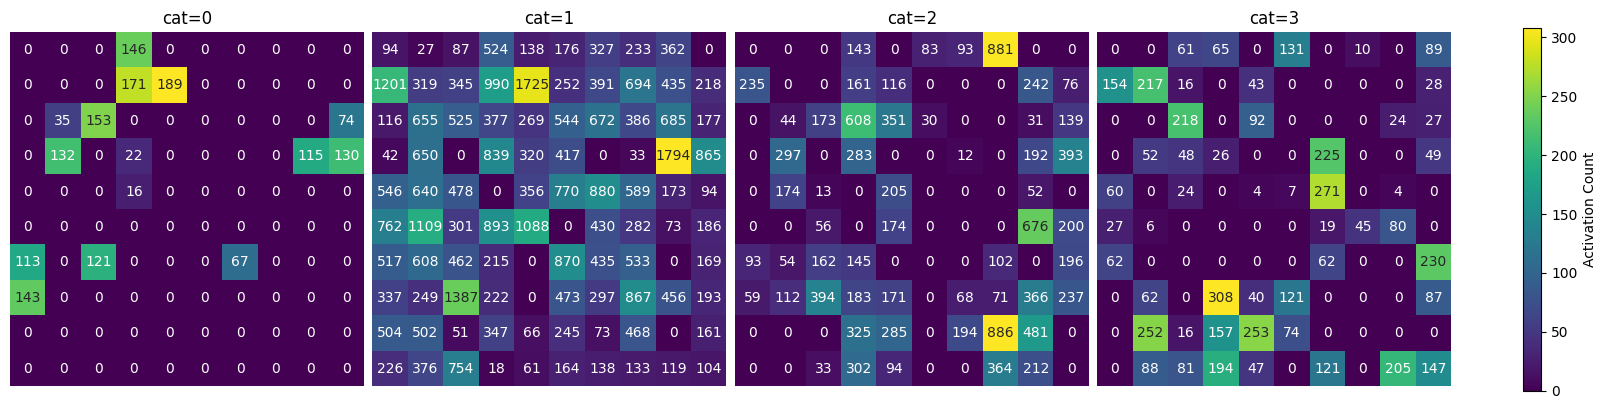

In [12]:

som_dim = (10,10)
hm_by_cat = compute_som_activation_by_category(model3, test_loader, device, som_dim)
plot_som_usage_by_category(hm_by_cat, som_dim)

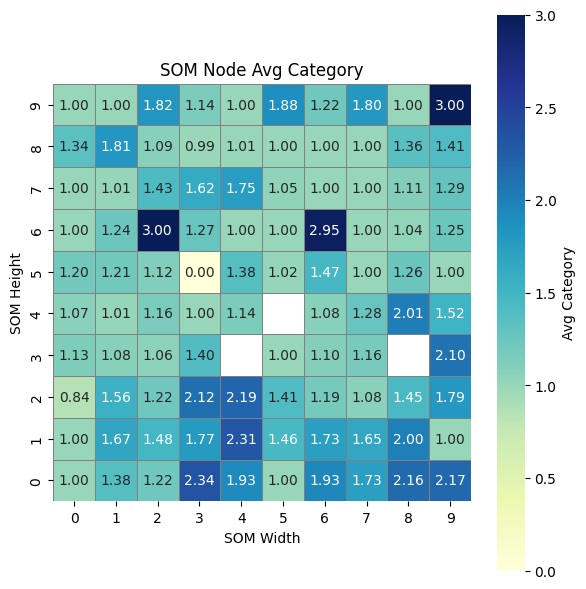

In [14]:
som_dim = (10,10)
avg_cat_map = compute_som_avg_category(model3, test_loader, device, som_dim)
plot_som_avg_category(avg_cat_map, som_dim)

z_all shape: (58231, 128)
y_all shape: (58231,)


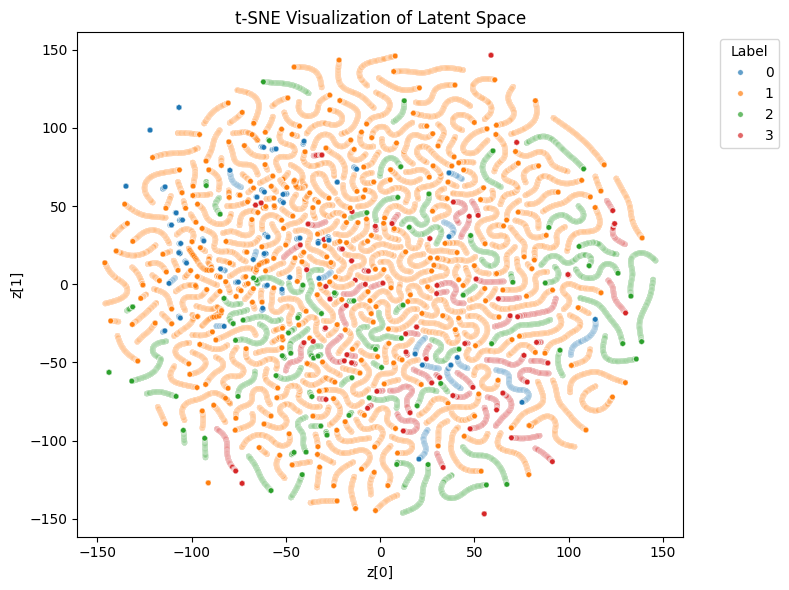

In [15]:
z_all, y_all = collect_latents(model3, data_loader= train_loader, device=device, max_batches=15)
plot_tsne(z_all, y_all)

/home/mei/anaconda3/envs/eicu/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/mei/anaconda3/envs/eicu/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


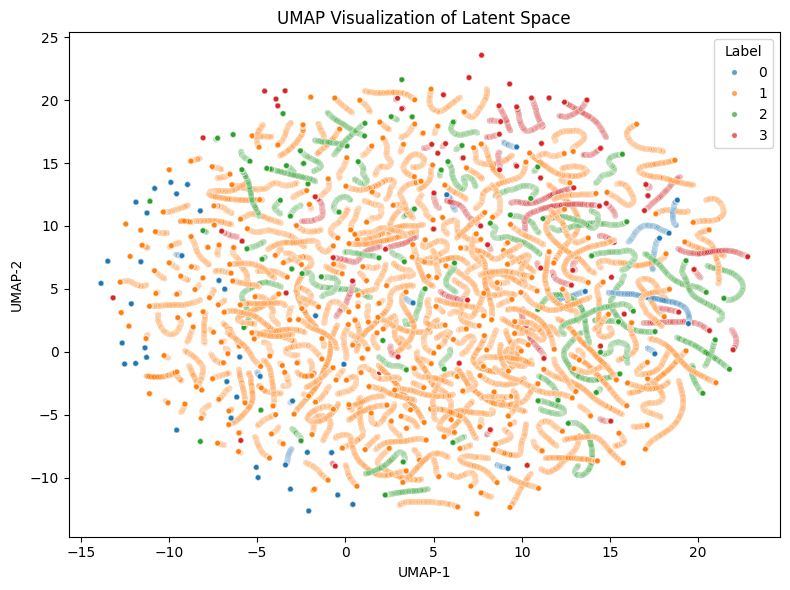

In [16]:
plot_umap(z_all, y_all)

## higher value to gamma, more weight to loss_{cah}

In [19]:
stage4_dir = os.path.join(base_dir, "stage4_higher_gamma")

model4,hist_joint =train_joint(model2, train_loader, val_loader,train_loader_p, 
                               device,  optimizer=optimizer_joint, 
                                start_epoch=0, epochs=100, save_dir=stage4_dir, kl_warmup_epochs= 50,
                                theta = 1, gamma = 200,kappa= 10, beta= 150, eta= 1,
                                patience = 20)

[Joint] Building patient_start_offset_global as dict...
[Joint] Offset dict built for 2150 patients. Total length: 263825


[Joint] Ep10: Calculating global target P...


[Joint] Ep10 Global P updated. Shape: torch.Size([263825, 100])


[Joint] Ep20: Calculating global target P...


[Joint] Ep20 Global P updated. Shape: torch.Size([263825, 100])


[Joint] Early stopping at epoch 21 due to no improvement for 20 epochs.
[Joint] Loading best model weights.



--- Latent Space Statistics ---
Analyzed 80417 valid timesteps.

--- mu (Mean of q(z|x)) ---
  Mean (overall): 0.0084
  Std (overall): 0.2078
  Per-dim mean:
tensor([ 4.3633e-02, -1.3423e-02, -1.7175e-02, -3.4452e-02,  1.1611e-02,
        -7.0700e-03, -3.9656e-02,  2.3675e-03, -3.0720e-02,  8.6482e-03,
         1.4272e-02,  1.0813e-02, -2.8537e-03, -3.7156e-03,  2.7663e-02,
         1.6537e-02, -6.3887e-04,  4.6500e-02,  4.7645e-03, -3.4016e-02,
        -6.6963e-03,  1.0872e-02,  1.7814e-02,  2.6976e-02,  1.7427e-02,
         2.6321e-02,  2.9450e-03, -3.6057e-01, -1.3752e-02,  5.0252e-01,
         9.2792e-03,  1.2681e-03, -2.9495e-02,  1.6219e-02,  4.2888e-04,
         3.9352e-02, -1.5962e-04,  1.0031e-02,  9.3195e-03, -1.7610e-02,
        -1.3778e-02,  9.7980e-03, -2.1548e-02,  3.3203e-01,  7.3774e-03,
         1.2099e-02,  4.9058e-03,  5.1010e-02,  2.1828e-02,  1.9612e-02,
        -1.8021e-02,  3.0353e-03,  3.1689e-02,  1.4917e-02,  1.6432e-02,
        -7.8980e-01, -1.4924e-03,  2.0

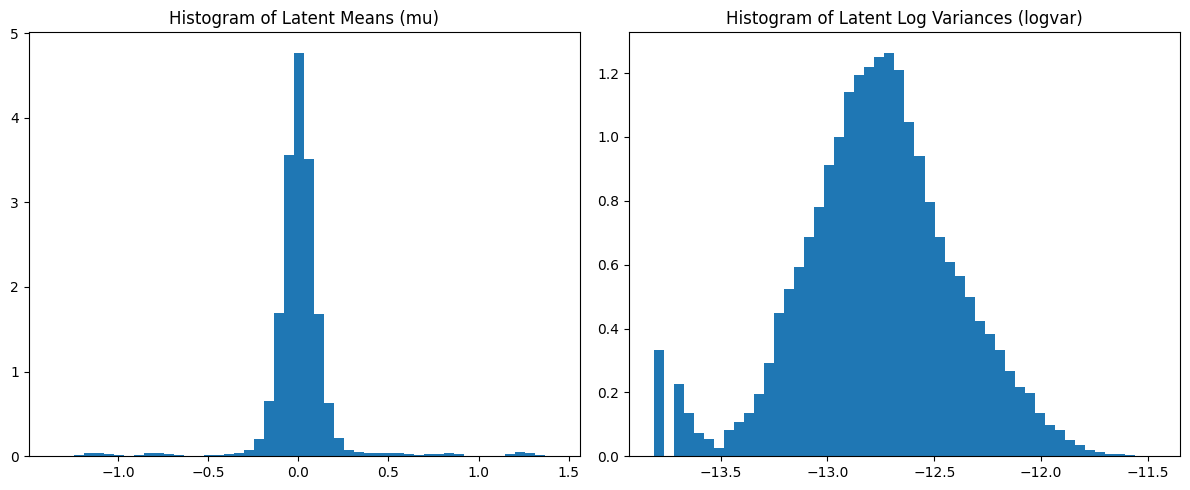

In [20]:
analyze_latent_stats(model4, train_loader, device, num_batches_to_analyze=20)

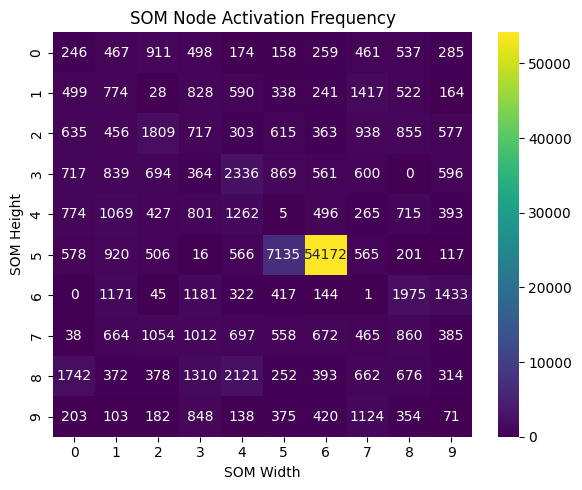

In [21]:
activation_map = compute_som_activation_heatmap(model4, test_loader, device)
plot_som_activation_heatmap(activation_map)

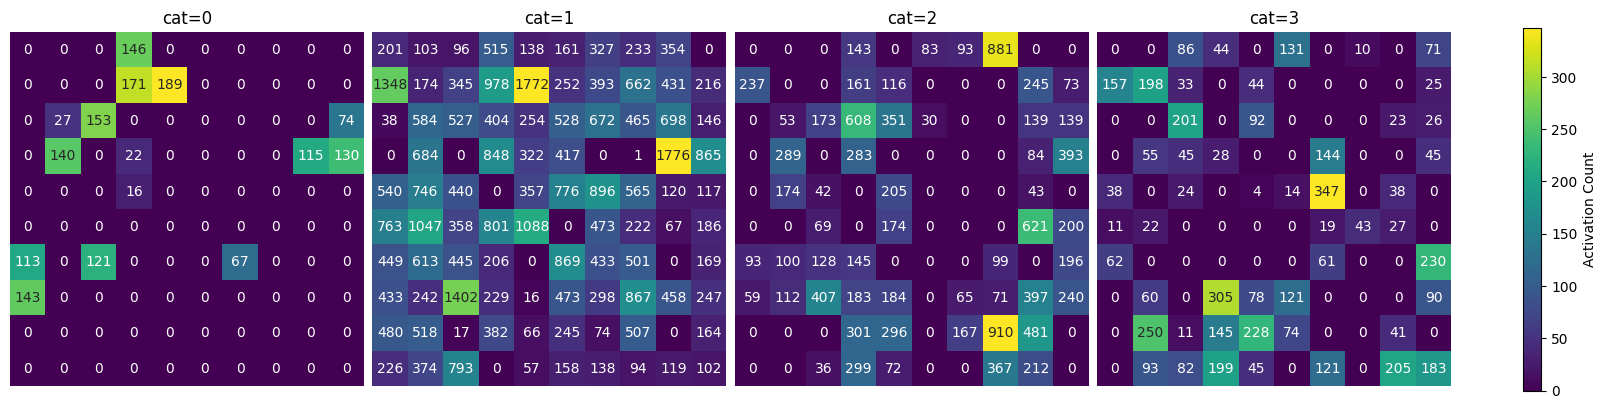

In [22]:
som_dim = (10,10)
hm_by_cat = compute_som_activation_by_category(model4, test_loader, device, som_dim)
plot_som_usage_by_category(hm_by_cat, som_dim)

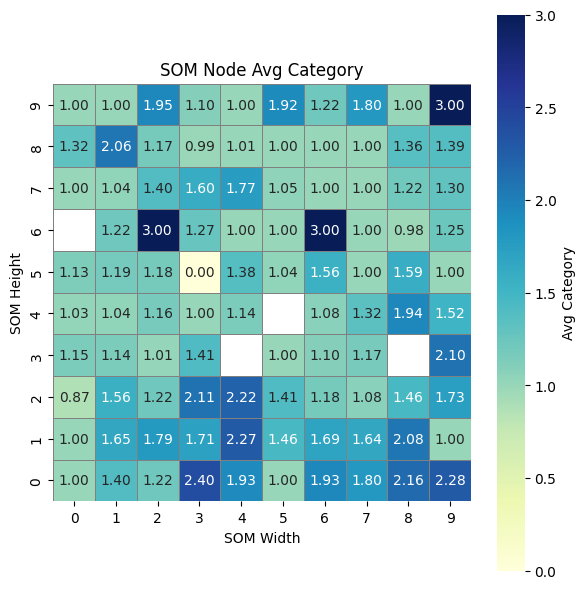

In [23]:
som_dim = (10,10)
avg_cat_map = compute_som_avg_category(model4, test_loader, device, som_dim)
plot_som_avg_category(avg_cat_map, som_dim)

## higher value to beta only, L_{som} gets mor weight 

In [24]:
stage5_dir = os.path.join(base_dir, "stage5_higher_beta")

model5,hist_joint_5 =train_joint(model2, train_loader, val_loader,train_loader_p, 
                               device,  optimizer=optimizer_joint, 
                                start_epoch=0, epochs=100, save_dir=stage5_dir, kl_warmup_epochs= 50,
                                theta = 1, gamma = 10,kappa= 10, beta= 200, eta= 1,
                                patience = 20)

[Joint] Building patient_start_offset_global as dict...
[Joint] Offset dict built for 2150 patients. Total length: 263825


[Joint] Ep10: Calculating global target P...


[Joint] Ep10 Global P updated. Shape: torch.Size([263825, 100])


[Joint] Ep20: Calculating global target P...


[Joint] Ep20 Global P updated. Shape: torch.Size([263825, 100])


[Joint] Early stopping at epoch 21 due to no improvement for 20 epochs.
[Joint] Loading best model weights.


In [5]:
stage5 = '/home/mei/nas/docker/thesis/data/model_results/retnet/resampled_60/stage5_higher_beta/best_joint.pth'
model5 = TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

model5.load_state_dict(torch.load(stage5, map_location=device,weights_only=True))

<All keys matched successfully>


--- Latent Space Statistics ---
Analyzed 77287 valid timesteps.

--- mu (Mean of q(z|x)) ---
  Mean (overall): 0.0085
  Std (overall): 0.2080
  Per-dim mean:
tensor([ 4.8857e-02, -1.1181e-02, -1.6565e-02, -2.5657e-02,  8.4658e-03,
        -1.5132e-02, -3.9618e-02,  5.5824e-03, -2.6128e-02,  1.0843e-02,
         1.0348e-02,  5.5329e-03, -7.8982e-03, -7.0321e-03,  2.6314e-02,
         1.3517e-02,  5.3513e-04,  4.5821e-02,  8.4415e-03, -3.1316e-02,
        -1.0691e-02,  1.1200e-02,  2.3924e-02,  2.3499e-02,  1.7699e-02,
         2.2957e-02,  2.4516e-03, -3.6207e-01, -1.5167e-02,  5.1102e-01,
         9.4459e-03,  3.8383e-03, -3.2161e-02,  1.4522e-02, -1.0662e-03,
         3.5219e-02,  1.4554e-03,  1.3420e-04,  1.1243e-02, -1.8512e-02,
        -9.3221e-03,  5.1746e-03, -1.9149e-02,  3.3897e-01,  9.0368e-03,
         1.1194e-02,  2.9093e-03,  5.9280e-02,  2.9614e-02,  2.3206e-02,
        -1.7138e-02,  8.3195e-03,  3.6914e-02,  1.9616e-02,  1.4924e-02,
        -7.9231e-01, -2.7749e-03,  2.2

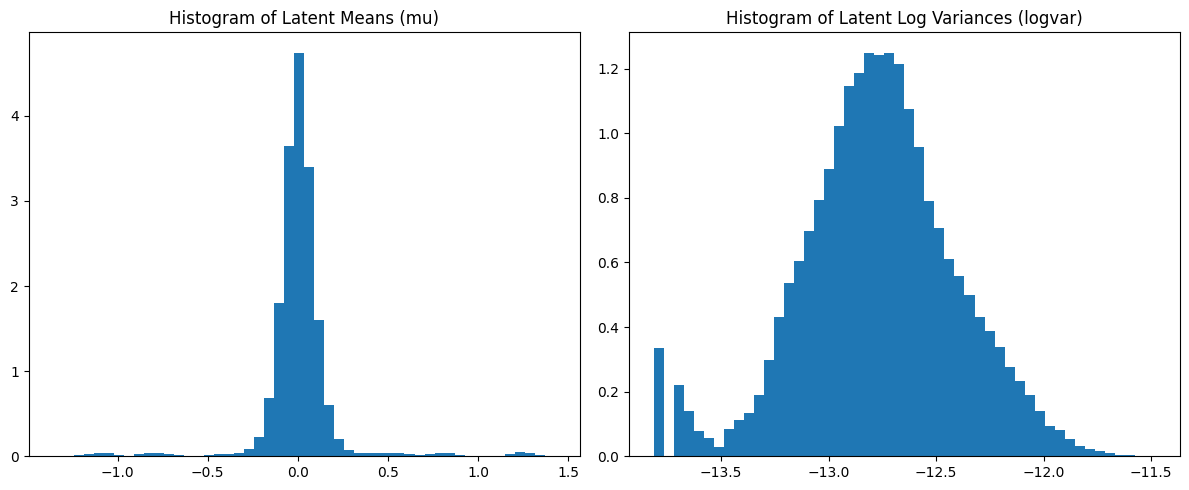

In [6]:
analyze_latent_stats(model5, train_loader, device, num_batches_to_analyze=20)

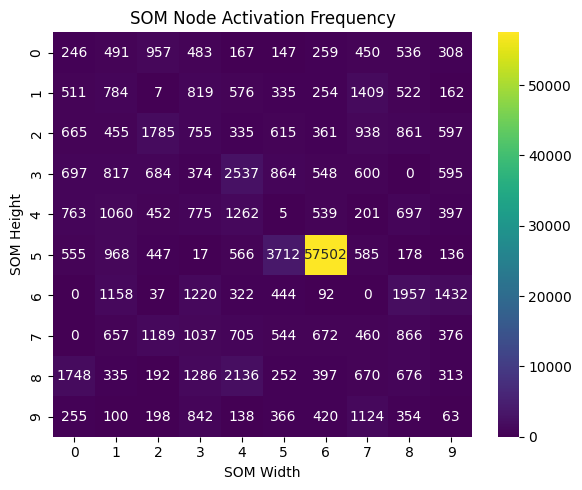

In [7]:
activation_map = compute_som_activation_heatmap(model5, test_loader, device)
plot_som_activation_heatmap(activation_map)

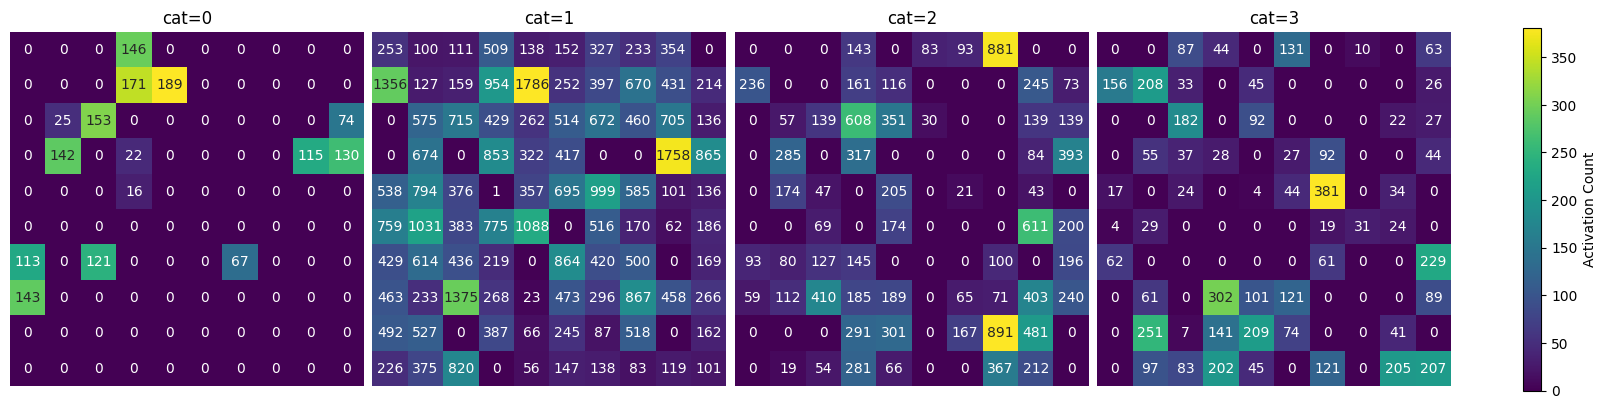

In [8]:
som_dim = (10,10)
hm_by_cat = compute_som_activation_by_category(model5, test_loader, device, som_dim)
plot_som_usage_by_category(hm_by_cat, som_dim)

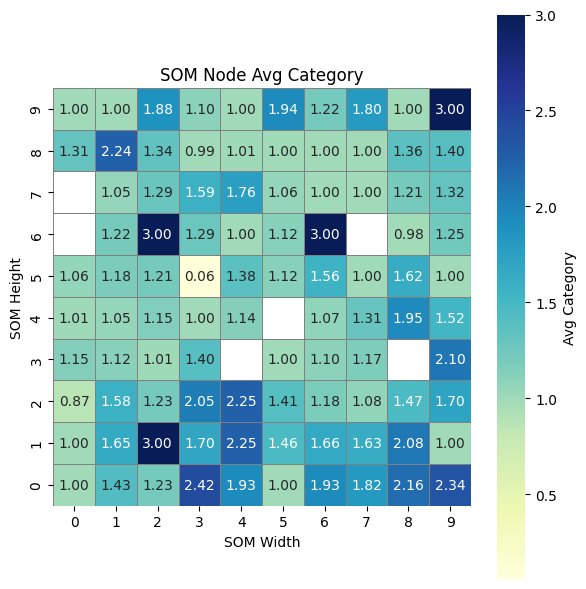

In [9]:
som_dim = (10,10)
avg_cat_map = compute_som_avg_category(model5, test_loader, device, som_dim)
plot_som_avg_category(avg_cat_map, som_dim)

In [6]:
stage2 = '/home/mei/nas/docker/thesis/data/model_results/retnet/resampled_60/stage2/best_som.pth'
model2 =  TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

model2.load_state_dict(torch.load(stage2, map_location=device,weights_only=True))


<All keys matched successfully>

## higer value to kappa， more weight to smooth

In [7]:
stage6_dir = os.path.join(base_dir, "stage6_higher_kappa")

model6,hist_joint_6 =train_joint(model2, train_loader, val_loader,train_loader_p, 
                               device,  optimizer=optimizer_joint, 
                                start_epoch=0, epochs=100, save_dir=stage6_dir, kl_warmup_epochs= 50,
                                theta = 1, gamma = 100, beta= 150, kappa= 200,
                                patience = 20)

[Joint] Building patient_start_offset_global as dict...
[Joint] Offset dict built for 2150 patients. Total length: 263825


[Joint] Ep10: Calculating global target P...


[Joint] Ep10 Global P updated. Shape: torch.Size([263825, 100])


[Joint] Ep20: Calculating global target P...


[Joint] Ep20 Global P updated. Shape: torch.Size([263825, 100])


[Joint] Early stopping at epoch 21 due to no improvement for 20 epochs.
[Joint] Loading best model weights.
